Hi there! :) 
This notebook is an exploratory data analysis of [Kaggle Solar AMS competition data set](https://www.kaggle.com/c/ams-2014-solar-energy-prediction-contest/data).

In [1]:
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import pickle

# Part 1: Exploring the variable we wish to predict - the daily solar energy

First, read in the prediction variable - the integrated solar energy from Sun rise to Sun set for every day from 1994-2012 as measured by pyranometers at 98 different Oklahoma Mesonet sites: 
$$y_{\rm train} = \int_{t=\rm sunrise}^{t= \rm 23:55 UTC} y(t) dt$$
where $y_{\rm train}$ is our total daily integrated solar energy, $t$ is the time, $y(t)$ is the measured solar energy from a pyranometer in $J m^{-2}$ (joules/meter^2), and $dt$ is a 5 minute interval. 

In [2]:
y_train = pd.read_csv('../Data/train.csv')
y_train.head()

,Date,ACME,ADAX,ALTU,APAC,ARNE,BEAV,BESS,BIXB,BLAC,...,VINI,WASH,WATO,WAUR,WEAT,WEST,WILB,WIST,WOOD,WYNO
0,19940101,12384900,11930700,12116700,12301200,10706100,10116900,11487900,11182800,10848300,...,10771800,12116400,11308800,12361800,11331600,10644300,11715600,11241000,10490100,10545300
1,19940102,11908500,9778500,10862700,11666400,8062500,9262800,9235200,3963300,3318300,...,4314300,10733400,9154800,12041400,9168300,4082700,9228000,5829900,7412100,3345300
2,19940103,12470700,9771900,12627300,12782700,11618400,10789800,11895900,4512600,5266500,...,2976900,11775000,10700400,12687300,11324400,2746500,3686700,4488900,9712200,4442100
3,19940104,12725400,6466800,13065300,12817500,12134400,11816700,12186600,3212700,8270100,...,3476400,12159600,11907000,12953100,11903700,2741400,4905000,4089300,11401500,4365000
4,19940105,10894800,11545200,8060400,10379400,6918600,9936300,6411300,9566100,8009400,...,6393300,11419500,7334400,10178700,7471500,8235300,11159100,10651500,10006200,8568300


We can see that each column of ``y_train`` corresponds to total daily solar energy at each Oklahoma Mesonet site. Now grab only the ``y_train`` corresponding to a specific station: 

In [3]:
station_name = y_train.columns.values[25]
daily_solar_energy = y_train[station_name]
date = y_train['Date']

Given that ``daily_solar_energy`` varies as a function of location on Earth's surface and day of year (due to Earth's seasons), lets convert each ``date`` to a day of year using a few algorithms. 

In [4]:
def doy(Y, M, D):
    """
    Given year, month, day return day of year
    Astronomical Algorithms, Jean Meeus, 2d ed, 1998, chap 7
    :param Y: year (int)
    :param M: month (int 1-12)
    :param D: day (float)
    :return: day of year.
    """
    if is_leap_year(Y):
        K = 1
    else:
        K = 2
    N = int((275 * M) / 9.0) - K * int((M + 9) / 12.0) + D - 30
    return N

In [5]:
def is_leap_year(year):
    """
    Check if year is leap year or not
    """
    if year % 100 == 0:
        return year % 400 == 0
    return year % 4 == 0

Now lets compute the day of the year (an integer from 1-365) for every ``date``:

In [6]:
dates_str = map(np.str, date.values)
day_of_year = np.array([doy(float(dates_str[i][0:4]), float(dates_str[i][4:6]), float(dates_str[i][6:])) for i in range(date.values.shape[0])])

Now we can plot ``day_of_year`` vs the ``daily_solar_energy``:

<IPython.core.display.Javascript object>


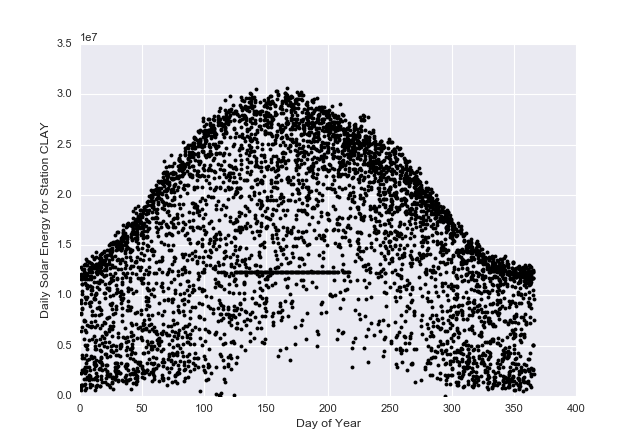

In [7]:
plt.plot(day_of_year, daily_solar_energy, 'k.')
plt.xlabel('Day of Year')
plt.ylabel('Daily Solar Energy for Station ' + station_name)

We see a few interesting aspects of the figure above: 
1. **There are bad/missing data as shown by the flat line from ``day_of_year`` 122 to 214**. It makes no sense for the pyranometers at each Oklahoma Mesonet site to measure the exact same ``daily_solar_energy`` multiple days in a row.

2. **The maximum ``daily_solar_energy`` for a given ``day_of_year`` clearly varies sinusoidally - the ``day_of_year`` is thus a very important feature.** This agrees well with expectations from physics, since on a clear day, with no clouds and no weather, the ``daily_solar_energy`` is easy predictable:
$${\rm Daily~Solar~Energy} = \frac{86000}{\pi}I_{SC}\bigg[1+0.034\cos\bigg(2\pi\frac{n}{365.25}\bigg)\bigg](\cos{\phi}\cos{\delta}\sin{\omega_{S}}+\omega_{S}\sin{\phi}\sin{\delta})$$
More details on the equation above can be found [here](http://www.itacanet.org/the-sun-as-a-source-of-energy/part-4-irradiation-calculations/). For our purposes, knowing that the maximum ``daily_solar_energy`` uniquely varies at each Oklahoma Mesonet site as a function of ``day_of_year`` and latitude and longitude suggests useful features would be longitude, latitude, and daily maximum solar energy. 

3. **There are many days where ``daily_solar_energy`` is below the maximum, and this is due to clouds and weather, as expected.** This suggests a useful feature would be a clear sky index.  
 

## Removing Bad Data from the ``daily_solar_energy``
Lets address \#1 above first, by removing the bad data from ``daily_solar_energy``. First grab all the unique values of ``daily_solar_energy`` as well as their indexes ``uniq_index`` and the number of times each unique value shows up ``uniq_cnts``: 

In [8]:
uniq, uniq_index, uniq_cnts = np.unique(daily_solar_energy, return_counts=True, return_index=True)

Now lets grab only indexes where the number of times each unique value of ``daily_solar_energy`` shows up more than 10 times. The reasoning here is that just by chance over 13 years, a few days in ``daily_solar_energy`` will appear more than once, but more than 10 times? That would be way out of the ordinary:

In [9]:
bad_uniques = np.where(uniq_cnts > 10)[0]

Now grab indexes of ``daily_solar_energy`` that correspond to these bad data:

In [10]:
bad_data_stat = np.where(daily_solar_energy == uniq[bad_uniques][0])[0]

Now check our work. We should see the bad data clearly selected in a plot of ``daily_solar_energy`` vs ``day_of_year``:

<IPython.core.display.Javascript object>


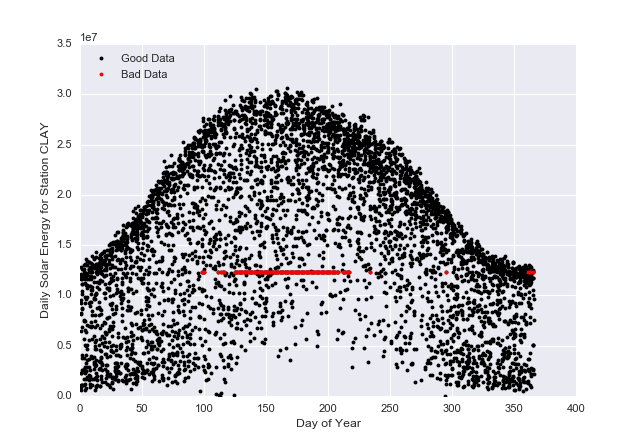

In [11]:
plt.plot(day_of_year, daily_solar_energy, 'k.', label='Good Data')
plt.plot(day_of_year[bad_data_stat], daily_solar_energy[bad_data_stat], 'r.', label='Bad Data')
plt.legend(loc='upper left')
plt.xlabel('Day of Year')
plt.ylabel('Daily Solar Energy for Station ' + station_name)

Finally, lets remove these bad data:

In [12]:
daily_solar_energy_cleaned = np.delete(daily_solar_energy.values, bad_data_stat.tolist())
day_of_year_cleaned = np.delete(day_of_year, bad_data_stat.tolist())

<IPython.core.display.Javascript object>


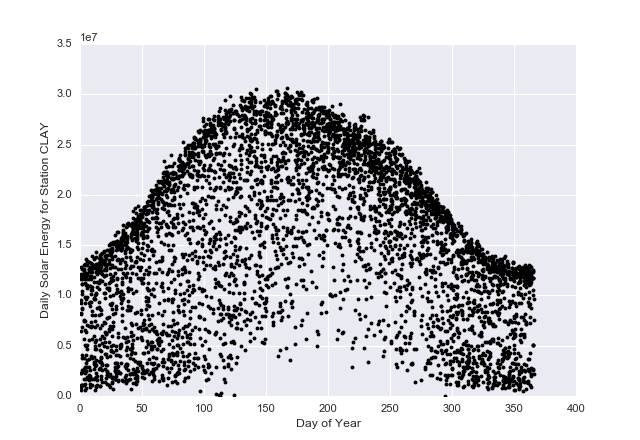

In [13]:
plt.plot(day_of_year_cleaned, daily_solar_energy_cleaned, 'k.')
plt.xlabel('Day of Year')
plt.ylabel('Daily Solar Energy for Station ' + station_name)

Success!

# Part 2: Exploring weather features

The weather features are 12, 15, 18, 21, and 24 hours ahead forecasts from 11 different global weather models at 144 different latitudes and longitudes across Oklahoma, and are described [here](https://www.kaggle.com/c/ams-2014-solar-energy-prediction-contest/data).  

Given that the ``daily_solar_energy`` as measured by pyranometers is the total diffuse irradiance from the sky on a tilted surface, i.e. $I_{\rm diffuse} = I_{\rm beam} + I_{\rm sky} + I_{\rm ground}$, we expect the most interesting weather features to be the forecasted downward shortwave radiative flux ``dswrf_sfc`` at the surface, and the upward shortwave radiative flux at the surface ``uswrf_sfc``. 

## Read in the weather data
Prior to exploring these features, the weather data and the ``daily_solar_energy`` had to be properly assembled from the unwieldy ``.nc`` files of the raw data with the ``assemble_data.py`` program located in the ``Code/`` directory [github repository](https://github.com/garciaev/PredictingSolarEnergy) for this project. 

``assemble_data.py`` produces a ``.csv`` of examples (rows) x features (columns). Columns 13-17 correspond to the downward shortwave radiative flux at the surface of the Earth: 

In [14]:
dswrf_sfc = pd.read_csv('../extra71/extra7_1.csv', usecols=(13, 14, 15, 16, 17))
dswrf_sfc.head()

,dswrf_sfc_12,dswrf_sfc_15,dswrf_sfc_18,dswrf_sfc_21,dswrf_sfc_24
0,0.0,31.428572,215.714279,520.000000,341.428558
1,0.0,30.000000,178.571426,440.000000,281.428558
2,0.0,31.428572,220.000000,534.285706,350.000000
3,0.0,31.428572,218.571426,530.000000,351.428558
4,0.0,30.000000,215.714279,520.000000,337.142853


`dswrf_sfc_12` is typically zero given that the start date of each weather model is 0:00 UTC, and 12:00 UTC is typically before Sun rise. 

``assemble_data.py`` also produces a ``.pickle`` file with the ``daily_solar_energy`` and station numbers arranged appropriately to match the weather data:

In [15]:
with open('../extra71/extra7_1.pickle', 'r') as f:
    daily_solar_energy, statnums, longs, lats, elevs, date, meth, debug = pickle.load(f)

## Visualize weather features relevant to predicting `daily_solar_energy`
Now lets plot a random portion of the total downward radiative flux `dswrf_sfc` summed over the entire day, and compare it to the variable we wish to predict, the `daily_solar_energy`:

<IPython.core.display.Javascript object>


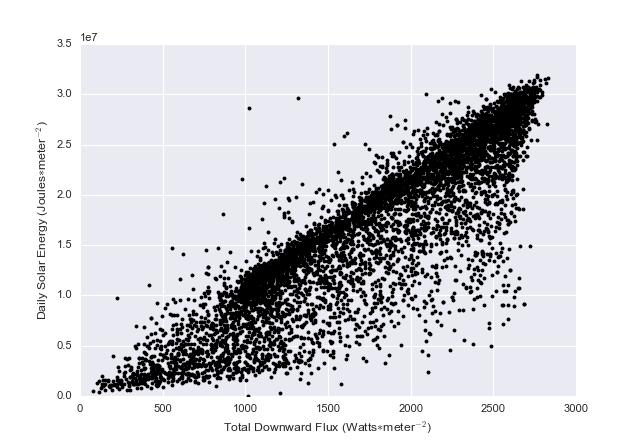

In [16]:
rand_ind = np.random.randint(daily_solar_energy.shape[0], size=7000)
plt.plot(dswrf_sfc.sum(axis=1).values[rand_ind], daily_solar_energy[rand_ind], 'k.')
plt.xlabel('Total Downward Flux (Watts$*$meter$^{-2}$)')
plt.ylabel('Daily Solar Energy (Joules$*$meter$^{-2}$)')

We can see from the figure above that downward radiative flux `dswrf_sfc` is strongly correlated with `daily_solar_energy` and will be useful feature for our machine learning algorithms. Furthermore, we have two different subgroups - days where `dswrf_sfc` matches linearly, and days where it does not. This also suggests that the maximum `dswrf_sfc` also varies with the day of year:

In [23]:
day_of_year = pd.read_csv('../extra71/extra7_1.csv', usecols=(2,)).values.flatten()

<IPython.core.display.Javascript object>


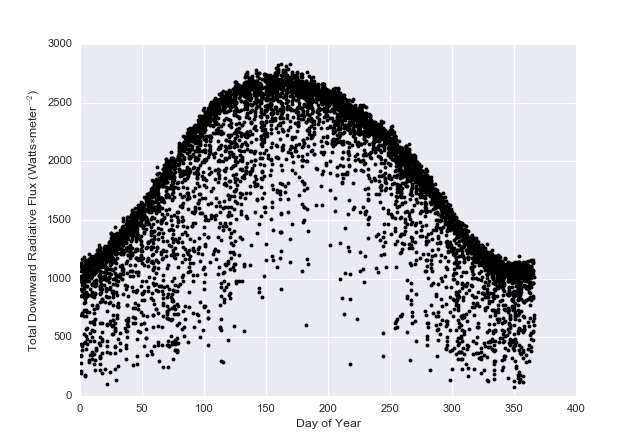

In [25]:
plt.plot(day_of_year[rand_ind], dswrf_sfc.sum(axis=1).values[rand_ind], 'k.')
plt.xlabel('Day of Year')
plt.ylabel('Total Downward Radiative Flux (Watts$*$meter$^{-2}$)')

As expected from the figure above, `dswrf_sfc` varies as a function of `day_of_year`, in much the same way `daily_solar_energy` does, which makes perfect sense from a physics point of view, given the equations for irradiance. 

In [35]:
uswrf_sfc = pd.read_csv('../extra71/extra7_1.csv', usecols=(73, 74, 75, 76, 77))
uswrf_sfc.head()

,uswrf_sfc_12,uswrf_sfc_15,uswrf_sfc_18,uswrf_sfc_21,uswrf_sfc_24
0,0.0,9.285714,49.714287,109.428574,75.285713
1,0.0,7.571429,37.857143,86.857140,58.000000
2,0.0,9.428572,52.428570,116.000000,79.428574
3,0.0,8.857142,49.857143,112.285713,77.857140
4,0.0,8.142858,48.857143,107.571426,71.142860


<IPython.core.display.Javascript object>


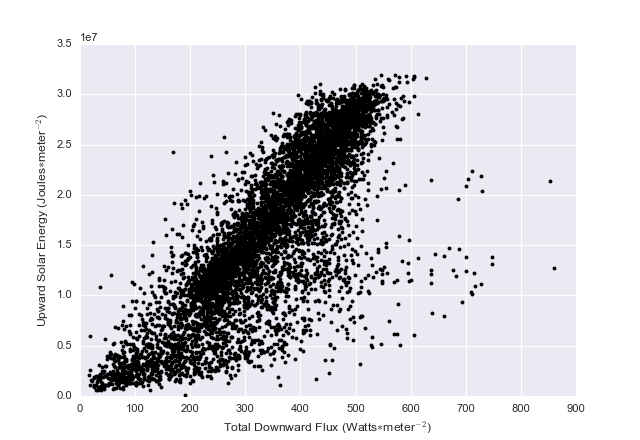

In [36]:
rand_ind = np.random.randint(daily_solar_energy.shape[0], size=7000)
plt.plot(uswrf_sfc.sum(axis=1).values[rand_ind], daily_solar_energy[rand_ind], 'k.')
plt.xlabel('Total Upward Flux (Watts$*$meter$^{-2}$)')
plt.ylabel('Daily Solar Energy (Joules$*$meter$^{-2}$)')

From the figure above, we see that the upward radiative flux at the surface `uswrf_sfc` is also linearly related to the `daily_solar_energy`, which also makes sense physics-wise.

In [50]:
uswrf_sfc = 0
pres_msl = 0
pwat_eatm = pd.read_csv('../extra71/extra7_1.csv', usecols=(23, 24, 25, 26, 27))
rand_ind = np.random.randint(daily_solar_energy.shape[0], size=20000)

<IPython.core.display.Javascript object>


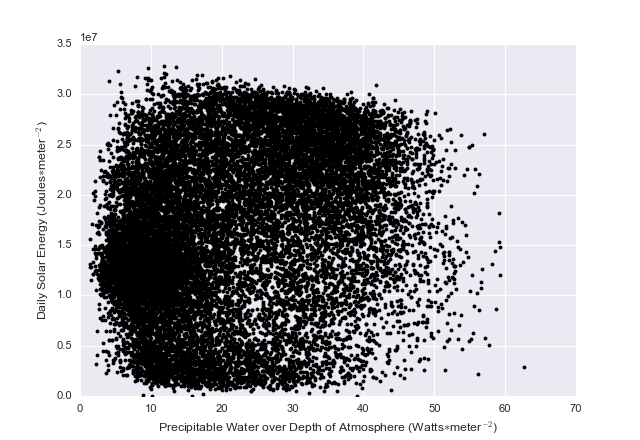

In [51]:
plt.plot(pwat_eatm['pwat_eatm_24'].values[rand_ind], daily_solar_energy[rand_ind], 'k.')
plt.xlabel('Precipitable Water over Depth of Atmosphere (Kg$*$meter$^{-2}$)')
plt.ylabel('Daily Solar Energy (Joules$*$meter$^{-2}$)')

From the figure above we can see atleast two distinct groups: when water vapor is low (10-20 Kg$*$meter$^{-2}$), the daily solar energy is also low, and vice versa. This bodes well for using a decision tree model such as XGBoost!